# Used Cars Case Study

### Project Brief

You have been hired as a data scientist at a used car dealership in the UK. The sales team have been having problems with pricing used cars that arrive at the dealership and would like your help. Before they take any company wide action they would like you to work with the Toyota specialist to test your idea. They have already collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

The presentation of your findings should be targeted at the Head of Sales, who has no technical data science background.

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

In [1]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from jupyterthemes import jtplot
jtplot.style()

## Exploratory Data Analysis

In [2]:
data = pd.read_csv('data/toyota.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [3]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


In [4]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [5]:
# Transform Data
data['price'] = data['price'].astype(float)
data['mileage'] = data['mileage'].astype(float)
# Remove data without engine size info
data = data[data['engineSize'] !=0]

## Distribution of key features

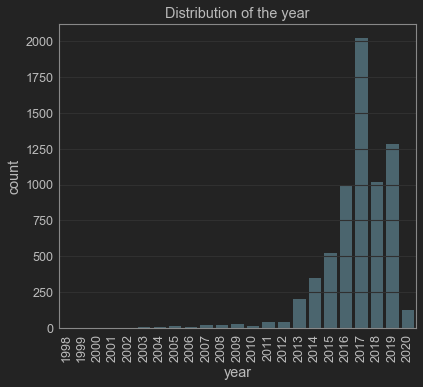

In [6]:
ax = sns.countplot(x='year', data=data, color='#456874')
ax.set_title('Distribution of the year')
ax.tick_params(axis='x', rotation=90)

We can notice that most of the vehicules were fabricated from 2010.

Text(0.5, 1.0, 'Distribution of the price')

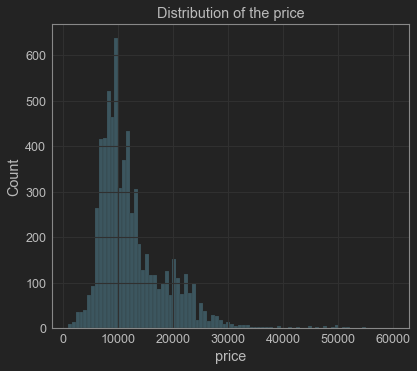

In [7]:
ax = sns.histplot(x='price', data=data, color='#456874')
ax.set_title('Distribution of the price')

Most vehicles have a list price below £35000.

Text(0.5, 1.0, 'Distribution of mileage')

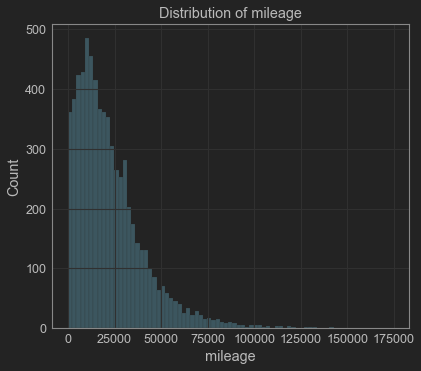

In [8]:
ax = sns.histplot(x='mileage', data=data, color='#456874')
ax.set_title('Distribution of mileage')

Text(0.5, 1.0, 'Distribution of engine size')

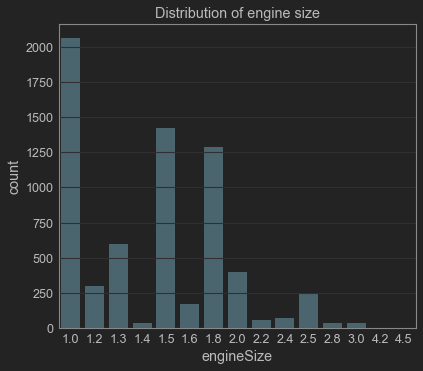

In [9]:
ax = sns.countplot(x='engineSize', data=data, color='#456874')
ax.set_title('Distribution of engine size')

## Relation between key features

Text(0.5, 0.98, 'Year vs Price')

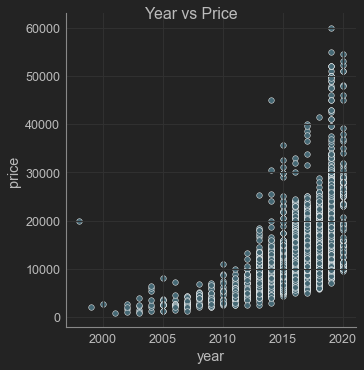

In [10]:
ax = sns.relplot(x='year', y='price', data=data, color='#456874')
ax.fig.suptitle('Year vs Price')

We observe a nonlinear relation between year and price, our target variable.

Text(0.5, 0.98, 'Engine size vs Price')

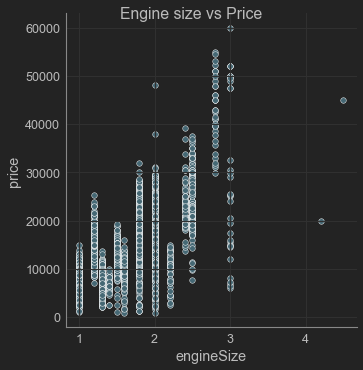

In [11]:
ax = sns.relplot(x='engineSize', y='price', data=data, color='#456874')
ax.fig.suptitle('Engine size vs Price')

We observe a nonlinear relation between engine size and price, our target variable.

Text(0.5, 0.98, 'Mileage vs Price')

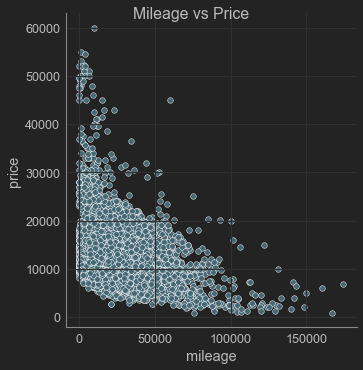

In [12]:
ax = sns.relplot(x='mileage', y='price', data=data, color='#456874')
ax.fig.suptitle('Mileage vs Price')

We observe a nonlinear relation between year and price, our target variable. Based on this is unlikely that a linear model could predict prices within the specifed error range.

In [13]:
# Transform categories to numeric
data = data.drop('model', axis=1)
data_numeric = pd.get_dummies(data)
data_numeric = data_numeric.drop(['transmission_Other', 'fuelType_Other'], axis=1)
# Remove outliers
data_numeric = data_numeric[data_numeric['price'] < 35000]
data_numeric = data_numeric[data_numeric['year'] > 2010]
data_numeric.shape

(6550, 12)

Text(0.5, 1.0, 'Correlation Between Features')

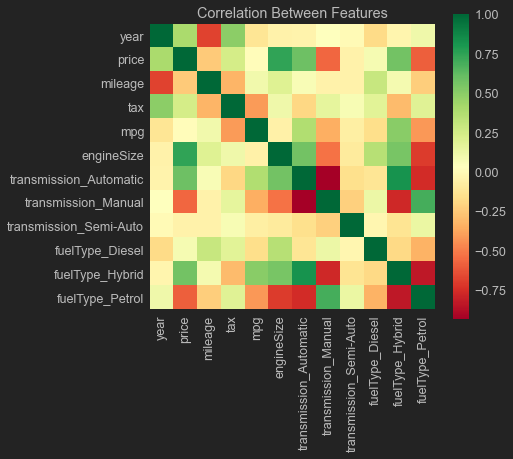

In [14]:
# Explore correlation
ax = sns.heatmap(data_numeric.corr(), square=True, cmap='RdYlGn')
ax.set_title('Correlation Between Features')

## Linear Models

In [15]:
#Creating feature and target variables
y = data_numeric['price'].values
X = data_numeric.drop('price', axis=1)
#X = data_numeric[['year', 'mileage', 'engineSize']]

In [16]:
# Linear Regression Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=23)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
print("Linear Regression RMSE: {}".format(rmse))
print("Linear Regression Score: {}".format(score))

Linear Regression RMSE: 2457.1893813639704
Linear Regression Score: 0.8032587484099978


C:\Users\dante\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14310902073.2609, tolerance: 20323738.700677503
  model = cd_fast.enet_coordinate_descent(


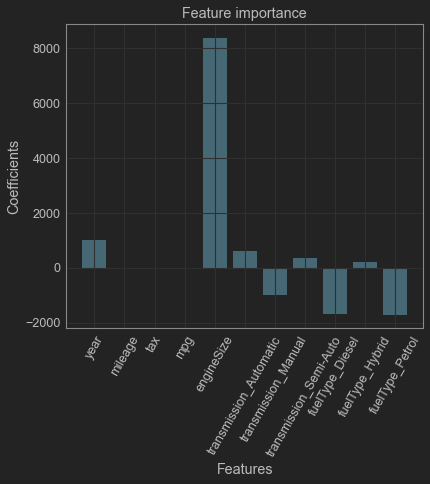

In [17]:
# Lasso Coefficients
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_
_ = plt.bar(range(len(X.columns)), lasso_coef, color='#456874')
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=60)
_ = plt.ylabel('Coefficients')
_ = plt.xlabel('Features')
_ = plt.title('Feature importance')
plt.show()

Asuming a linear correlation the engine size is our best predictor for price.

In [18]:
# Ridge Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=23)
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
score = ridge.score(X_test, y_test)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
print("Ridge Regression RMSE: {}".format(rmse))
print("Ridge Regression Score: {}".format(score))

Ridge Regression RMSE: 2457.1893813639704
Ridge Regression Score: 0.796806170004115


In [19]:
# ElasticNet with tuned parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}
elastic_net = ElasticNet()
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)
gm_cv.fit(X_train, y_train)
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet RMSE: {}".format(rmse))

C:\Users\dante\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29953434312.804714, tolerance: 9628097.087971378
  model = cd_fast.enet_coordinate_descent(
C:\Users\dante\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29675741127.847603, tolerance: 9729478.936856363
  model = cd_fast.enet_coordinate_descent(
C:\Users\dante\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29972023396.85168, tolerance: 9846314.22633728
  model = cd_fast.enet_coordinate_descent(
C:\Users\dante\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

Tuned ElasticNet l1 ratio: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.8061927934199926
Tuned ElasticNet RMSE: 2459.9908330380676


## Decision Tree Models

In [20]:
# Simple Decision Tree Regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=23)
dt.fit(X_train, y_train)
y_pred =  dt.predict(X_test)
y_pred_train =  dt.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train)**(1/2)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
score = dt.score(X_test, y_test)
MSE_CV = - cross_val_score(dt, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("Decision Tree RMSE: {}".format(rmse))
print("Decision Tree Score: {}".format(score))
print("Decision Tree RMSE train: {}".format(rmse_train))
print("Decision Tree RMSE CV: {}".format(MSE_CV.mean()**(1/2)))

Decision Tree RMSE: 2690.6510059739235
Decision Tree Score: 0.7640972999784655
Decision Tree RMSE train: 2645.0305188889647
Decision Tree RMSE CV: 2677.5505963637615


In [21]:
# Stochastic Boosted Regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
sgbt = GradientBoostingRegressor(max_depth=5, subsample=0.7, max_features=0.3, n_estimators=400, random_state=23)
sgbt.fit(X_train, y_train)
y_pred =  sgbt.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
score = sgbt.score(X_test, y_test)
print("Stochastic Gradient Boosting RMSE: {}".format(rmse))
print("Stochastic Gradient Boosting Score: {}".format(score))

Stochastic Gradient Boosting RMSE: 1115.198781838471
Stochastic Gradient Boosting Score: 0.959475026188806


Gradient Boosting RMSE: 1109.6928000161563
Gradient Boosting Score: 0.9598741997754172


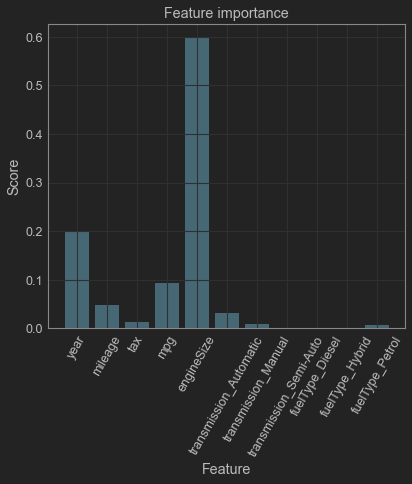

In [22]:
# Gradient Boosted Regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
gbt = GradientBoostingRegressor(n_estimators=300, max_depth=4, random_state=23)
gbt.fit(X_train, y_train)
y_pred =  gbt.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
score = gbt.score(X_test, y_test)
print("Gradient Boosting RMSE: {}".format(rmse))
print("Gradient Boosting Score: {}".format(score))

features = gbt.feature_importances_
_ = plt.bar(range(len(X.columns)), features, color='#456874')
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=60)
_ = plt.ylabel('Score')
_ = plt.xlabel('Feature')
_ = plt.title('Feature importance')
plt.show()

In [34]:
lower_gbt = GradientBoostingRegressor(loss="quantile", alpha=0.05, n_estimators=300, max_depth=4, random_state=23)
upper_gbt = GradientBoostingRegressor(loss="quantile", alpha= 0.95, n_estimators=300, max_depth=4, random_state=23)

lower_gbt.fit(X_train, y_train)
upper_gbt.fit(X_train, y_train)

predictions = pd.DataFrame(y_test, columns=['target']) 

predictions['average'] = y_pred
predictions['lower'] = lower_gbt.predict(X_test)
predictions['upper'] = upper_gbt.predict(X_test)

predictions['over range'] = (predictions['average'] - predictions['target']) > 1500

predictions['over range'].sum() / len(predictions)



0.04834605597964377

After tuning hyperparameters, Gradient Boosting is the model that performs the best. It gives us an error of £1,109, enough to our requirements. The most important feature is engine size followed by year and mpg.

## Results
From the exploratory analysis we observed that the relationship between some features was nonlinear. However, We implemented a couple of linear models to test this hypothesis. The highest score we were able to obtain was: 0.80.

Knowing that the problem was non-linear, We opted to try Decision Trees. The simple decision tree was not enough to obtain a good performance. Gradient Boosting with Decision Tress gave us the best score. After tuning some hyperparameters, We were able to get a score of 0.96. The average error for a new prediction is in the range of £1,109. This range allows us to make predictions within the limit of £1,500 to sell those cars.

## Considerations
The dataset could be biased from the fact that all the data comes only from Toyota. It's possible that the model would not work well with vehicles from other manufacturers. We need to train the model with data from other manufacturers to improve it.


## Future Work
We could explore other features to improve the model:
* overall appearance
* manufacturer name
* days_listed
* etc

We could build a classification model to cluster vehicles based on profit or other features.